# Visual inspection of SDTW soft alignment matrix

Johannes Zeitler (johannes.zeitler@audiolabs-erlangen.de), 2023

Code base for ISMIR 2023 paper 

In [1]:
import os
import sys

In [2]:
# make only GPU 0 visible
os.environ['CUDA_VISIBLE_DEVICES']='0'

#device_train = 'cpu'
device_train = 'cuda:0'

#device_test = 'cpu'
device_test = 'cuda:0'

In [ ]:
import libfmp.b
import libfmp.c3
import libfmp.c4
import libfmp.c5
import librosa
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from time import time, gmtime, strftime
import torch 
import torch.nn.functional as F

from libdl.nn_models import *
from libdl.data_loaders.parallelDataset import ParallelHCQTLoader 
from libdl.metrics import early_stopping
from libdl.training import Trainer
from libdl.data_loaders.parallelDataset import ParallelHCQTLoader 
from libdl.nn_losses.soft_dtw_cuda import SoftDTW


from torchinfo import summary
import h5py
from scipy.signal import convolve2d

In [4]:
data_path = "../Data/Schubert_Winterreise_hcqt"

version = "SC06"
song="11"

hcqtFile = os.path.join(data_path, "Schubert_D911-%s_%s.h5"%(song, version))

with h5py.File(hcqtFile, "r") as f:
    hcqt = f["hcqt"][:]
    chroma = f["chroma"][:]
    
f.close()

In [5]:
fs = 57.578
oneSidedContext=37
sec_start = 26.6 
nFrames = 500

frame_start = int(sec_start*fs)
frame_stop = frame_start+nFrames

chroma_snip_context = chroma[0,0,:,frame_start-oneSidedContext : frame_stop+oneSidedContext]
chroma_snip = chroma[0,0,:,frame_start : frame_stop]

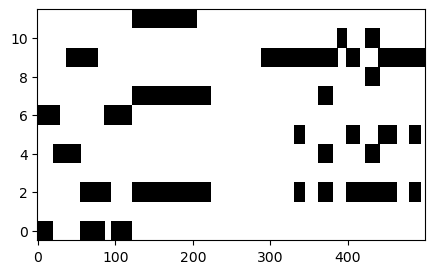

In [6]:
plt.figure(figsize=(5,3))
plt.imshow(chroma_snip, origin='lower', cmap='gray_r', aspect='auto', interpolation='none')
plt.show()

In [ ]:
target = chroma_snip

nReps = []
new_target = None
last_target = None

optEl = []

nReps.append(1)
for frame in range(target.shape[1]):
    # first frame
    if frame == 0:
        new_target = target[:,frame][:,None]
        last_target = target[:,frame][:,None]
        
        optEl.append([0,0])

        continue   
    # check if new label
    if not np.array_equal(target[:,frame][:,None], last_target):
        last_target = target[:,frame][:,None]
        new_target = np.concatenate((new_target,last_target),1)
        nReps.append(1)

        optEl.append([optEl[-1][0]+1, optEl[-1][1] + 1])

    else:
        nReps[-1] += 1
        optEl.append([optEl[-1][0]+1, optEl[-1][1]])
        
opt_wp = np.array(optEl)

In [8]:
plot_loader = ParallelHCQTLoader(fileList=[hcqtFile],
          #segments_per_file=1,
          target_indices=[frame_start],
                                 #stride=1000,
          #avg_frames_per_segment=100,
          max_workers=1, 
          batch_size=1,
          numContextFrames=nFrames+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=nFrames,
          weak_labels=True,
          expand_weak_labels=False)

plot_loader_strong = ParallelHCQTLoader(fileList=[hcqtFile],
          #segments_per_file=1,
          target_indices=[frame_start],
                                 #stride=1000,
          #avg_frames_per_segment=100,
          max_workers=1, 
          batch_size=1,
          numContextFrames=nFrames+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=nFrames,
          weak_labels=False,
          expand_weak_labels=False)

plot_loader_unfold = ParallelHCQTLoader(fileList=[hcqtFile],
          #segments_per_file=1,
          target_indices=[frame_start],
                                 #stride=1000,
          #avg_frames_per_segment=100,
          max_workers=1, 
          batch_size=1,
          numContextFrames=nFrames+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=nFrames,
          weak_labels=True,
          expand_weak_labels=True)

In [9]:
for (x_weak,y_weak) in plot_loader:
    break
    
for (x_ref,y_ref) in plot_loader_strong:
    break
    
for (x_unfold,y_unfold) in plot_loader_unfold:
    break

In [10]:
def get_opt_warping_path_stretched(short_len, stretched_len, warping_path_short):
    opt_warping_path_stretched = []
    stretched_indices = np.linspace(0, short_len, stretched_len, endpoint=False).astype(int)

    #warping_path_short = opt_warping_path_list[1]

    curr_stretched_ind = 0
    short_ind_prev = warping_path_short[0]
    for i, short_ind in enumerate(warping_path_short):
        if short_ind_prev != short_ind:
            curr_stretched_ind += n_reps

        n_reps = np.sum(stretched_indices==short_ind)

        for j in range(n_reps):
            opt_warping_path_stretched.append([i, curr_stretched_ind + j])

        short_ind_prev = short_ind
        #curr_stretched_ind += n_reps

    return np.stack(opt_warping_path_stretched, axis=1)

In [11]:
opt_wp_stretched = get_opt_warping_path_stretched(short_len=y_weak.shape[2], stretched_len=nFrames, warping_path_short=opt_wp[:,1])

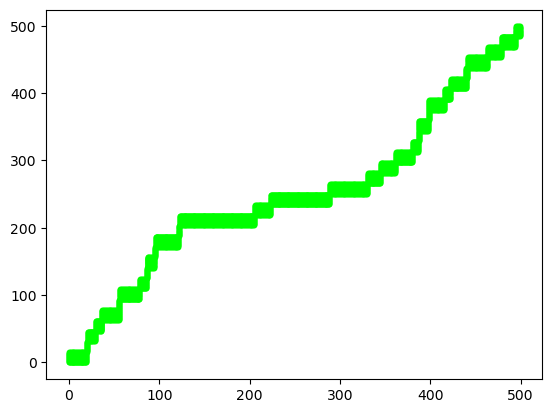

In [12]:
plt.figure()
plt.scatter(opt_wp_stretched[0,:], opt_wp_stretched[1,:], color='lime', s=10)#
plt.show()

In [13]:
plot_setups=[{   'gamma': 0.1,
                 'gamma_scheduler':False,
                 'prior_scheduler':False,
                 'label': 'const. gamma 0.1',
                 'save_name': 'baseline_constGamma_gamma01',
                 'uniqueTargets':True},
                
                {'gamma': 10.0,
                 'gamma_scheduler':False,
                 'prior_scheduler':False,
                    'label': 'const. gamma 10',
                    'save_name': 'baseline_constGamma_gamma10',
                    'uniqueTargets':True},
                
                {'gamma': 10.0,
                 'gamma_scheduler':True,
                 'prior_scheduler':False,
                    'label': 'gamma scheduling',
                    'save_name': 'gammaScheduling',
                    'uniqueTargets':True},
              
            {    'gamma': 0.1,
                 'gamma_scheduler':False,
                 'prior_scheduler':True,
                 'label': 'diag. prior 13',
                 'save_name': 'diagPrior',
                 'uniqueTargets':True},
            
             {   'gamma': 0.1,
                 'gamma_scheduler':False,
                 'prior_scheduler':False,
                 'label': 'W2, gamma 0.1',
                 'save_name': 'unfolding',
                 'uniqueTargets':False},
            ]

plot_epochs=[1,25]

In [14]:
# Set model parameters
n_chan_input=5               # C
n_chan_layers=[20,20,10,1]   # N0, N1, N2, N3
n_bins_in=216                # P * B = 72 * 3
n_bins_out=12                # chromas
a_lrelu=0.3
p_dropout=0.2


In [15]:
diagPrior_schedule={"initial_weight": 3,
                "final_weight": 0,
                "steps_const" : 5,
                "steps_decay": 5,
                "nu": 1e3}

gamma_schedule={"initial_gamma":10,
                "steps_const": 10,
                "steps_decay": 10,
                "final_gamma":.1}

def get_gamma_from_schedule(schedule, epoch):
    if epoch < schedule["steps_const"]:
        return schedule["initial_gamma"]
    elif (epoch >= schedule["steps_const"]) and (epoch < schedule["steps_const"]+schedule["steps_decay"]):
        return schedule["initial_gamma"] + (schedule["final_gamma"] - schedule["initial_gamma"])/schedule["steps_decay"] * (epoch-schedule["steps_const"])
    else:
        return schedule["final_gamma"]

def get_priorWeight_from_schedule(schedule, epoch):

    if epoch < schedule["steps_const"]:
        return schedule["initial_weight"]
    elif (epoch >= schedule["steps_const"]) and (epoch < schedule["steps_const"]+schedule["steps_decay"]):
        return schedule["initial_weight"] + (schedule["final_weight"] - schedule["initial_weight"])/schedule["steps_decay"] * (epoch-schedule["steps_const"])
    else:
        return schedule["final_weight"]

In [16]:
def get_diag_prior(N, M, nu=1e4):
    diagPath = np.linspace(0, M, N, endpoint=False).astype(int)

    frame_durations = np.zeros(M)
    for w1 in diagPath:
        frame_durations[w1]+=1
    D_prior = np.zeros((M, N))
    curr_fr_start = 0
    curr_fr_end = 0
    for fr, dur in enumerate(frame_durations.astype(int)):
        curr_fr_end = curr_fr_start + dur
        D_prior[fr, curr_fr_start : curr_fr_end] = 1
        #slope_start = max([0, curr_fr_start - dfr])     
        #slope_end = min([nFrames, curr_fr_end + dfr])       
        #opt_warping_path_smooth[fr, slope_start:curr_fr_start] = np.arange(curr_fr_start - slope_start)/(curr_fr_start - slope_start)
        #opt_warping_path_smooth[fr, curr_fr_end : slope_end] = np.arange(slope_end - curr_fr_end)[::-1]/(slope_end - curr_fr_end)

        D_prior[fr, :curr_fr_start] = np.exp(- (np.arange(curr_fr_start)-curr_fr_start)**2 / (2*nu))
        D_prior[fr, curr_fr_end:] = np.exp(- (np.arange(curr_fr_end, N)-curr_fr_end)**2 / (2*nu))
        curr_fr_start = curr_fr_end
    return 1-D_prior.transpose()

D_prior = torch.Tensor(get_diag_prior(nFrames, y_weak.shape[2], nu=diagPrior_schedule['nu'])[None,:]).to(device_test)

In [17]:
save_dir = "../Models/Checkpoints"

In [ ]:
for setup in plot_setups:
    
    save_name = setup["save_name"]
    
    fig, ax = plt.subplots(2, 1 ,figsize=(5,9))
    
    for iEpoch, load_epoch in enumerate(plot_epochs):

        if setup['gamma_scheduler']:
            gamma  =get_gamma_from_schedule(gamma_schedule, load_epoch-1)
        else:
            gamma = setup['gamma']            
        
        if setup['prior_scheduler']:
            prior_weight = get_priorWeight_from_schedule(diagPrior_schedule, load_epoch-1)
        else:
            prior_weight = 0

        crit = SoftDTW(use_cuda=True, gamma=gamma, normalize=False, sharp=False, sharp_weight_by_avg_alignment_sum=False,
                      dist_func=None)

        model_name = "Chroma_Estimation_weakTargets_%s_epoch%i.pt"%(save_name, load_epoch)

        model = basic_cnn_segm_sigmoid(n_chan_input, n_chan_layers, n_bins_in, n_bins_out, a_lrelu, p_dropout)
        model.load_state_dict(torch.load(os.path.join(save_dir, model_name)))

        model.to(device_test)
        model.eval()

        model.zero_grad()
        y_pred = model(x_weak.to(device_test))
        
        if setup['uniqueTargets']:
            loss_ = crit(y_pred, y_weak.to(device_test), D_prior=D_prior*prior_weight)
            loss_.backward()
            E_cuda = crit.dtw_class.e_matrix[0]
            E = E_cuda.cpu().detach().numpy().transpose()
            ax[iEpoch].imshow(E, origin='lower', aspect='auto', interpolation='none', cmap='gray_r', clim=[0,1])
            ax[iEpoch].plot(opt_wp[:,0], opt_wp[:,1], color='lime', linewidth=2, alpha=.7)
        else:
            loss_ = crit(y_pred, y_unfold.to(device_test), D_prior=0)
            loss_.backward()
            E_cuda = crit.dtw_class.e_matrix[0]
            E = E_cuda.cpu().detach().numpy().transpose()
            
            ax[iEpoch].imshow(convolve2d(E, np.ones((5,5)), mode='same'), origin='lower', aspect='auto', interpolation='none', cmap='gray_r', clim=[0,1])
            ax[iEpoch].scatter(opt_wp_stretched[0,:], opt_wp_stretched[1,:], color='lime', s=.05, alpha=.2, marker='.')#

        ax[iEpoch].set_title("Epoch %i"%(load_epoch), fontsize=10)
        
        ax[iEpoch].set_xlabel("Predicted sequence (frames)", fontsize=10)
        ax[iEpoch].set_ylabel("Target sequence (frames)", fontsize=10)
        
    fig.suptitle(setup['label'])
    plt.show()